In [38]:
import torch
import sys
sys.path.append("../")
from models.diff_model import diff_model
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

In [39]:
loadDir = "../models/datav3_attempt5_8GPU_SoftFlash_RoPE2d_2AccSteps_140batchsize_stage1"
# loadDir = "../models/datav3_attempt4_8GPU_SoftFlash_RoPE2dV2_2AccSteps"
loadFile = "model_ema_149000s.pkl"
loadDefFile = "model_params_149000s.json"
# loadDir = "../models/datav3_attempt4_8GPU_SoftFlash_RoPE2dV2_2AccSteps_TextLoss"
# loadFile = "model_ema_15000s.pkl"
# loadDefFile = "model_params_15000s.json"
device = "gpu"

In [40]:
### Model Creation

# Create a dummy model
inCh = 16
class_dim = 768
patch_size = 2
dim = 1024
hidden_scale = 4.0
num_heads = 8
attn_type = "cosine"
MLP_type = "gelu"
num_blocks = 20
positional_encoding = "RoPE"
device = "gpu"

model = diff_model(
    inCh=inCh,
    class_dim=class_dim,
    patch_size=patch_size,
    dim=dim,
    hidden_scale=hidden_scale,
    num_heads=num_heads,
    MLP_type=MLP_type,
    attn_type=attn_type,
    num_blocks=num_blocks,
    positional_encoding=positional_encoding,
    device=device,
)

# Load in the model weights
model.loadModel(loadDir, loadFile, loadDefFile)

# Load on device
if device == "gpu":
    model = model.cuda()
else:
    model = model
model.device = model.c_proj.weight.device

# Load in the text encoders and VAE
model.load_text_encoders()

Loading checkpoint shards: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


In [41]:
!nvidia-smi

Thu Apr  3 12:07:50 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   29C    P0    67W / 400W |  16724MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  On   | 00000000:0F:00.0 Off |                    0 |
| N/A   

In [42]:
def sample_once(
        batch_size=2,
        num_steps=50,
        text_input="",
        width=256,
        height=256,
        w=0.1,
        sampler="euler",
        seed=-1,
    ):
    # Create generator seed
    if seed != -1:
        generator = torch.Generator()
        generator.manual_seed(seed)
    else:
        generator = None
    
    # Sample the model
    noise = model.sample_imgs(batch_size, num_steps, text_input, w, height, width, False, True, sampler, generator)
            
    # Convert the sample image to 0->255
    # and show it
    plt.close('all')
    plt.axis('off')
    noise = (((noise + 1)/2)*255)
    noise = torch.clamp(noise.cpu().detach().int(), 0, 255)
    for i, img in enumerate(noise):
        plt.imshow(img.permute(1, 2, 0))
        # plt.savefig(f"test_{i}.png", bbox_inches='tight', pad_inches=0, )
    return

    # Image evolution gif
    plt.close('all')
    fig, ax = plt.subplots()
    ax.set_axis_off()
    for i in range(0, len(imgs)):
        imgs[i] = (((imgs[i] + 1)/2)*255)
        imgs[i] = torch.clamp(imgs[i].cpu().detach().int(), 0, 255).permute(1, 2, 0)
        title = plt.text(imgs[i].shape[0]//2, -5, f"t = {i}", ha='center')
        imgs[i] = [plt.imshow(imgs[i], animated=True), title]
    animate = animation.ArtistAnimation(fig, imgs, interval=1, blit=True, repeat_delay=1000)
    animate.save(out_gifname, writer=animation.PillowWriter(fps=gif_fps))

100%|██████████| 100/100 [00:06<00:00, 14.94it/s]


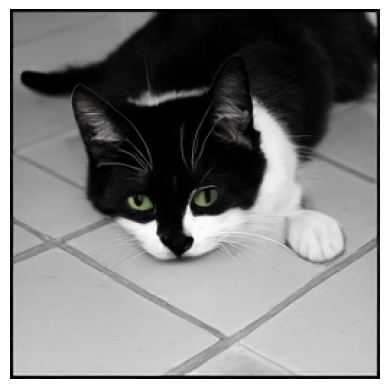

In [44]:
batch_size = 1
num_steps = 100
text_input = "A black and white cat lies on a tiled floor."
width = int(16 * 16)
height = int(16 * 16)
CFG_scale = 5
sampler = "euler"
seed = -1

sample_once(batch_size, num_steps, text_input, width, height, CFG_scale, sampler, seed)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:19<00:00,  5.23it/s]


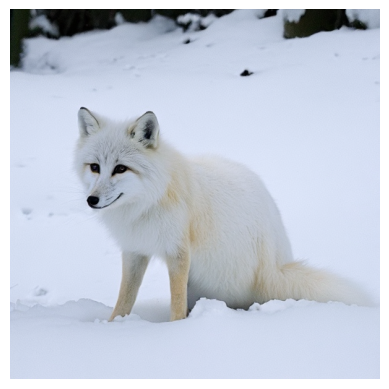

In [25]:
batch_size = 1
num_steps = 100
text_input = "A white fox in the snow"
width = int(32 * 16)
height = int(32 * 16)
CFG_scale = 5
sampler = "euler"
seed = -1

sample_once(batch_size, num_steps, text_input, width, height, CFG_scale, sampler, seed)

100%|██████████| 50/50 [00:03<00:00, 14.42it/s]


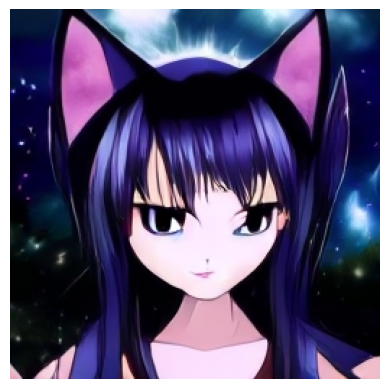

In [ ]:
batch_size = 1
num_steps = 50
text_input = "anime neko girl with cat ears, cinematic, amazing background, magic"
width = int(16 * 16)
height = int(16 * 16)
CFG_scale = 7
sampler = "euler"
seed = -1

sample_once(batch_size, num_steps, text_input, width, height, CFG_scale, sampler, seed)